# Importing necessary libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import PowerTransformer, StandardScaler
import seaborn as sns
from scipy import stats
from sklearn.feature_selection import mutual_info_regression
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor
import xgboost as xgb
from sklearn.model_selection import GridSearchCV,train_test_split
from sklearn.metrics import mean_squared_error, r2_score

# Loading the dataset

In [2]:
master_df = pd.read_csv('AM_MAsterData.csv')
df = master_df.copy()

In [3]:
df.head()

,Author/Paper,Powder Material,Substrate Material,Spot Size (mm),Power (W),Mass Flowrate (g/min),Travel Velocity (mm/min),Height (mm),Width (mm),Contact Angle (deg),Aspect Ratio (H/W)
0,El Cheikh,316L,316L,0.53,180,1.5,300.0,0.47,0.56,NaN,0.839
1,El Cheikh,316L,316L,0.53,180,1.5,600.0,0.19,0.50,NaN,0.380
2,El Cheikh,316L,316L,0.53,180,1.5,900.0,0.15,0.43,NaN,0.349
3,El Cheikh,316L,316L,0.53,180,3.0,300.0,0.73,0.41,NaN,1.780
4,El Cheikh,316L,316L,0.53,180,3.0,600.0,0.39,0.38,NaN,1.026


In [4]:
df.describe()

,Spot Size (mm),Power (W),Mass Flowrate (g/min),Travel Velocity (mm/min),Height (mm),Width (mm),Contact Angle (deg),Aspect Ratio (H/W)
count,303.000000,387.000000,387.000000,387.000000,351.000000,351.000000,265.000000,315.000000
mean,1.973630,584.139535,9.967144,340.787080,0.451635,1.328989,84.665245,0.378279
std,1.397092,949.288049,10.738164,184.992889,0.465068,1.076509,54.084430,0.326047
min,0.530000,150.000000,1.500000,100.200000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,198.500000,2.880000,233.000000,0.180500,0.631000,25.000000,0.127500
50%,1.000000,276.000000,5.502000,300.000000,0.320000,1.162000,93.100000,0.322000
75%,3.200000,360.000000,12.000000,408.000000,0.600500,1.707000,130.000000,0.592500
max,6.000000,5700.000000,70.000000,1200.000000,3.270000,6.030000,168.000000,2.893000


In [5]:
df.columns

Index(['Author/Paper', 'Powder Material', 'Substrate Material',
       'Spot Size (mm)', 'Power (W)', 'Mass Flowrate (g/min)',
       'Travel Velocity (mm/min)', 'Height (mm)', 'Width (mm)',
       'Contact Angle (deg)', 'Aspect Ratio (H/W)'],
      dtype='object')

# Feature Engineering

## Dropping unnecessary columns

In [6]:
df.drop(['Author/Paper'], inplace = True, axis=1)

## Handling Null values

In [7]:
df.shape

(387, 10)

In [8]:
print((df.isnull().sum() / len(df) * 100).round(2))

Powder Material              0.00
Substrate Material           0.00
Spot Size (mm)              21.71
Power (W)                    0.00
Mass Flowrate (g/min)        0.00
Travel Velocity (mm/min)     0.00
Height (mm)                  9.30
Width (mm)                   9.30
Contact Angle (deg)         31.52
Aspect Ratio (H/W)          18.60
dtype: float64


### Spot size and Contact Angle, Height and Width

- 21%, 31% are manageable for imputation

- `Spot Size`, `Contact Angle` are too important to remove from our EDA.

- Dropping these rows would lose 21% of your dataset

- `Height` and `Width` are also important features, they have outliers also and so cannot be imputed with mean/median. It is best to impute them with KNNImputer as well

We will use advanced imputation technique called as KNN imputer

In [9]:
# Statistics before imputation
df.describe()

,Spot Size (mm),Power (W),Mass Flowrate (g/min),Travel Velocity (mm/min),Height (mm),Width (mm),Contact Angle (deg),Aspect Ratio (H/W)
count,303.000000,387.000000,387.000000,387.000000,351.000000,351.000000,265.000000,315.000000
mean,1.973630,584.139535,9.967144,340.787080,0.451635,1.328989,84.665245,0.378279
std,1.397092,949.288049,10.738164,184.992889,0.465068,1.076509,54.084430,0.326047
min,0.530000,150.000000,1.500000,100.200000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,198.500000,2.880000,233.000000,0.180500,0.631000,25.000000,0.127500
50%,1.000000,276.000000,5.502000,300.000000,0.320000,1.162000,93.100000,0.322000
75%,3.200000,360.000000,12.000000,408.000000,0.600500,1.707000,130.000000,0.592500
max,6.000000,5700.000000,70.000000,1200.000000,3.270000,6.030000,168.000000,2.893000


In [10]:
from sklearn.impute import KNNImputer
# Use related features for better imputation
imputer = KNNImputer(n_neighbors=19) #Rule of thumb says 'n_neighbours' should be square root of number of data points
# Select features that might be related to Spot Size
features_for_imputation = ['Spot Size (mm)', 'Contact Angle (deg)','Height (mm)','Width (mm)']
# Perform imputation
df[features_for_imputation] = imputer.fit_transform(master_df[features_for_imputation])

In [11]:
#
df.describe()

,Spot Size (mm),Power (W),Mass Flowrate (g/min),Travel Velocity (mm/min),Height (mm),Width (mm),Contact Angle (deg),Aspect Ratio (H/W)
count,387.000000,387.000000,387.000000,387.000000,387.000000,387.000000,387.000000,315.000000
mean,2.182849,584.139535,9.967144,340.787080,0.491477,1.359897,87.036219,0.378279
std,1.322402,949.288049,10.738164,184.992889,0.462454,1.030575,47.675509,0.326047
min,0.530000,150.000000,1.500000,100.200000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,198.500000,2.880000,233.000000,0.198000,0.670000,56.842105,0.127500
50%,2.000000,276.000000,5.502000,300.000000,0.357000,1.320000,92.900000,0.322000
75%,3.200000,360.000000,12.000000,408.000000,0.700000,1.732447,121.052632,0.592500
max,6.000000,5700.000000,70.000000,1200.000000,3.270000,6.030000,168.000000,2.893000


Note: As we can see there are no major changes in statistics post imputing the values

In [12]:
print((df.isnull().sum() / len(df) * 100).round(2))

Powder Material              0.0
Substrate Material           0.0
Spot Size (mm)               0.0
Power (W)                    0.0
Mass Flowrate (g/min)        0.0
Travel Velocity (mm/min)     0.0
Height (mm)                  0.0
Width (mm)                   0.0
Contact Angle (deg)          0.0
Aspect Ratio (H/W)          18.6
dtype: float64


### Aspect Ratio
<b>Imputing target variables is generally not recommended because:</b>

- Can introduce bias in model training
- May lead to unreliable model performance
- Creates artificial relationships
- Makes model evaluation less reliable


<b>18% is significant but manageable loss of data</b>

- You'll still have 82% of data for training
- Better to have less but reliable data
- Maintains data integrity

In [13]:
df = df.dropna(subset=['Aspect Ratio (H/W)'])

In [14]:
print(df.shape)
print(print((df.isnull().sum() / len(df) * 100).round(2)))

(315, 10)
Powder Material             0.0
Substrate Material          0.0
Spot Size (mm)              0.0
Power (W)                   0.0
Mass Flowrate (g/min)       0.0
Travel Velocity (mm/min)    0.0
Height (mm)                 0.0
Width (mm)                  0.0
Contact Angle (deg)         0.0
Aspect Ratio (H/W)          0.0
dtype: float64
None


## Outliers
<b>Note: We have `intentional outliers` in the dataset and so removing them is not a good idea. 

# Splitting the data into train and test splits

In [15]:
# Separate features and target

df_train, df_test = train_test_split(df, test_size=0.1, random_state=0)
df_train.shape, df_test.shape

((283, 10), (32, 10))

# Transformations

For handling skewness in the data, we need to perform box-cox transformation

 `Spot size`, `Power`, `Mass FlowRate`, `Travel Velocity`, `Height`, `Width` are positively skewed as per our EDA, and so we will have to use a box-cox transformation

In [16]:
def apply_box_cox_transformation(df_train, df_test, skewed_features):
    """
    Apply Box-Cox transformation to positively skewed features
    
    Parameters:
    -----------
    df : pandas DataFrame
        Input dataframe
    skewed_features : list
        List of features to transform
    
    Returns:
    --------
    df_transformed : pandas DataFrame
        DataFrame with transformed features
    power_transformer : PowerTransformer
        Fitted transformer object
    """
    # Create copy of dataframe
    df_train_transformed = df_train.copy()
    df_test_transformed = df_test.copy()
    
    # Initialize transformer
    power_transformer = PowerTransformer(method='box-cox', standardize=False)
    
    # Function to plot distribution before and after transformation
    def plot_distribution(data_original, data_transformed, feature):
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
        
        # Original distribution
        sns.histplot(data_original, ax=ax1, kde=True)
        ax1.set_title(f'Original Distribution of {feature}')
        ax1.set_xlabel(feature)
        
        # Transformed distribution
        sns.histplot(data_transformed, ax=ax2, kde=True)
        ax2.set_title(f'Transformed Distribution of {feature}')
        ax2.set_xlabel(f'{feature} (Box-Cox transformed)')
        
        plt.tight_layout()
        plt.show()
    
    # Print skewness before and after transformation
    print("\nSkewness Before and After Box-Cox Transformation:")
    print("-" * 50)
    print(f"{'Feature':<20} {'Before':>10} {'After':>10}")
    print("-" * 50)
    
    # Transform features
    features_to_transform = []
    for feature in skewed_features:
        # Check if feature has all positive values
        if df[feature].min() <= 0:
            print(f"\nWarning: {feature} has zero or negative values.")
            print("Adding minimum value to make all values positive...")
            shift_value = abs(df[feature].min()) + 1
            df_train_transformed[feature] = df[feature] + shift_value
            df_test_transformed[feature] = df[feature] + shift_value
        
        features_to_transform.append(feature)
    
    # Fit and transform
    transformed_train_data = power_transformer.fit_transform(df_train_transformed[features_to_transform])
    transformed_test_data = power_transformer.transform(df_test_transformed[features_to_transform])
    
    # Update transformed features in dataframe
    for i, feature in enumerate(features_to_transform):
        # Store original data
        original_data = df[feature].copy()
        
        # Update transformed data
        df_train_transformed[feature] = transformed_train_data[:, i]
        df_test_transformed[feature] = transformed_test_data[:, i]
        
        # Calculate skewness
        skew_before = stats.skew(original_data)
        skew_after = stats.skew(df_train_transformed[feature])
        
        # Print skewness values
        print(f"{feature:<20} {skew_before:>10.3f} {skew_after:>10.3f}")
        
        # Plot distribution
        plot_distribution(original_data, df_train_transformed[feature], feature)
    
    return df_train_transformed, df_test_transformed, power_transformer


Skewness Before and After Box-Cox Transformation:
--------------------------------------------------
Feature                  Before      After
--------------------------------------------------

Adding minimum value to make all values positive...

Adding minimum value to make all values positive...
Spot Size (mm)            1.037      0.070


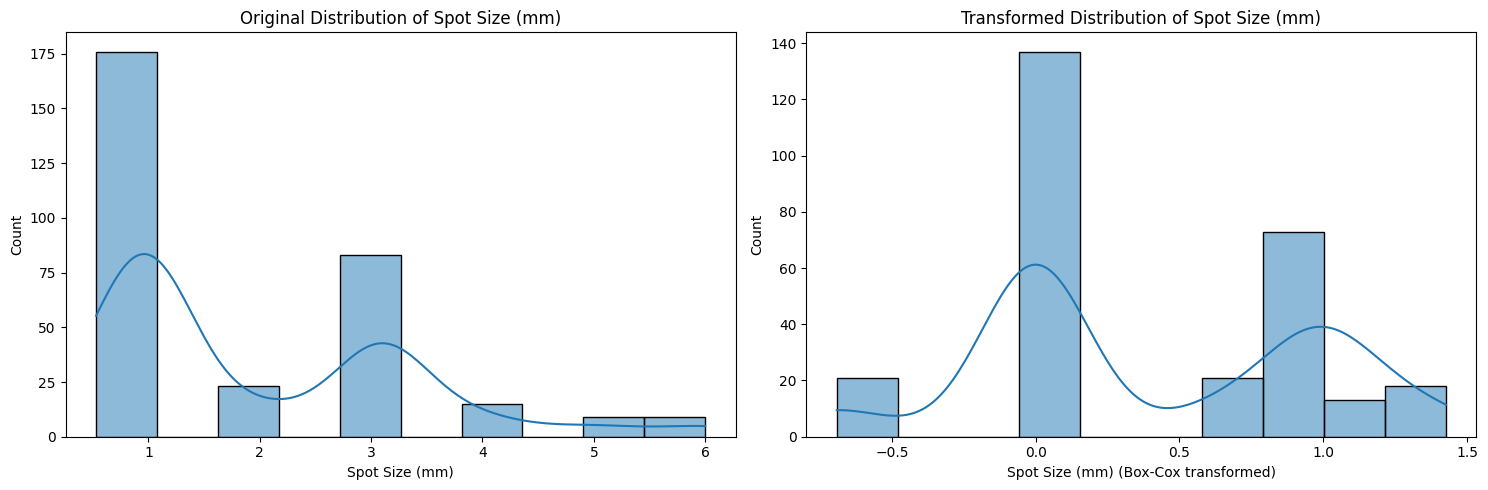

Power (W)                 4.473      0.313


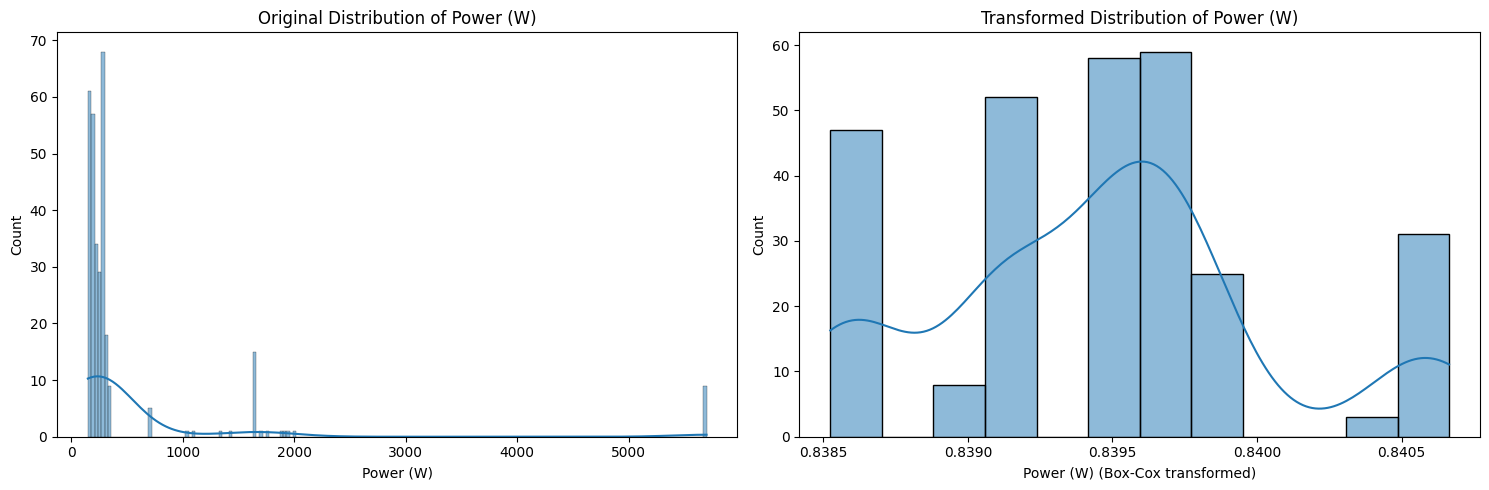

Mass Flowrate (g/min)      2.595      0.145


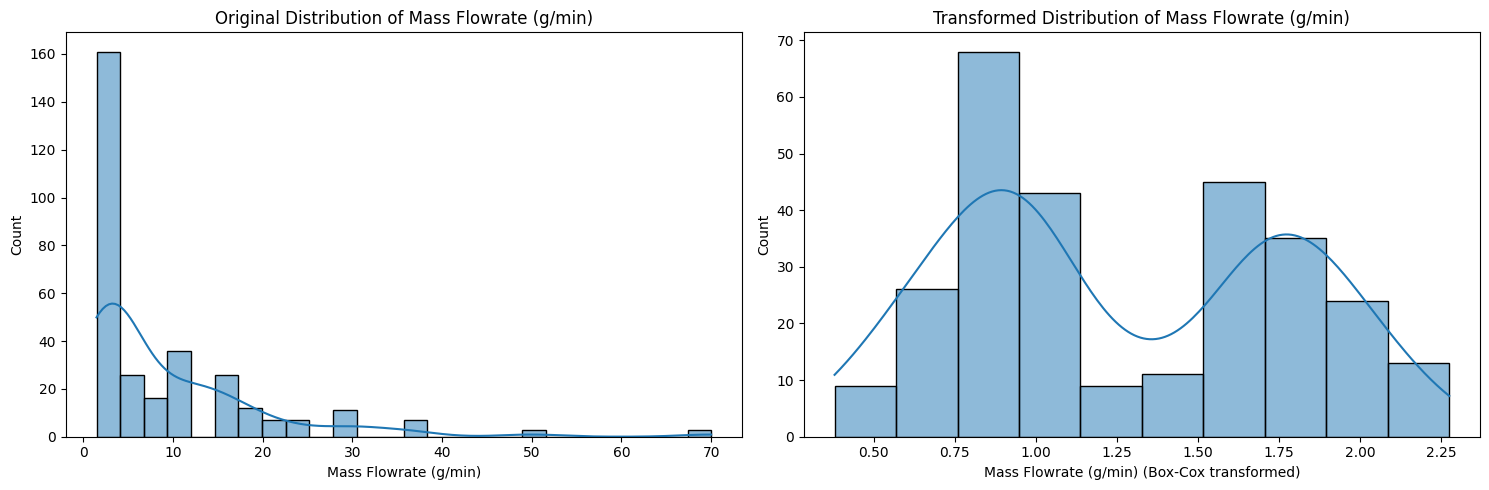

Travel Velocity (mm/min)      1.604      0.005


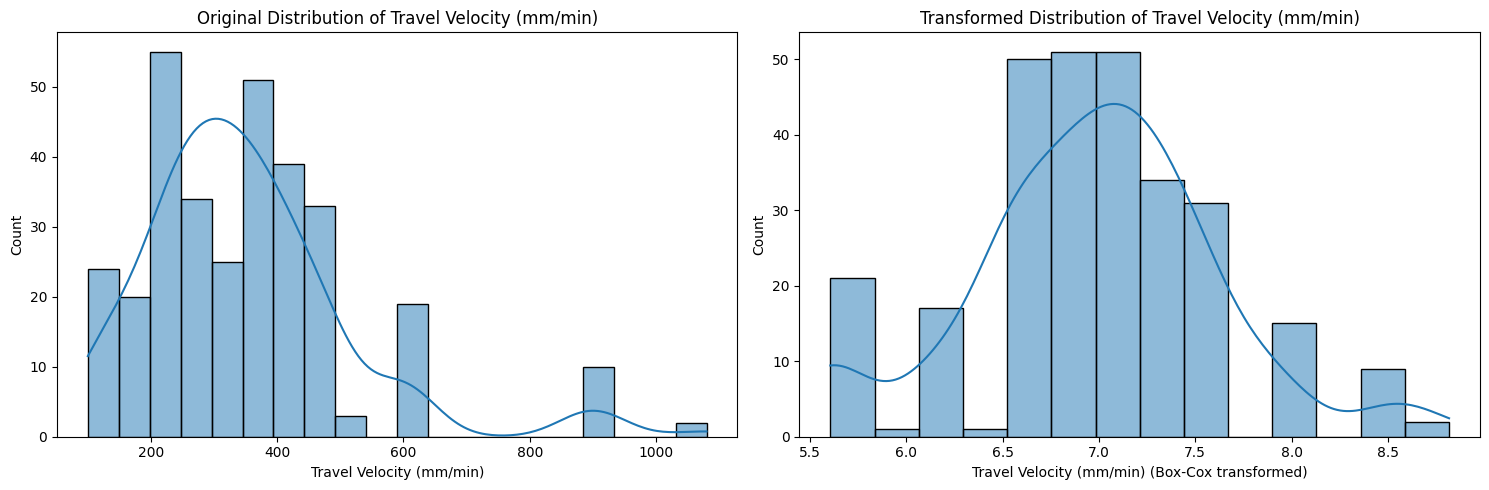

Height (mm)               3.325      0.062


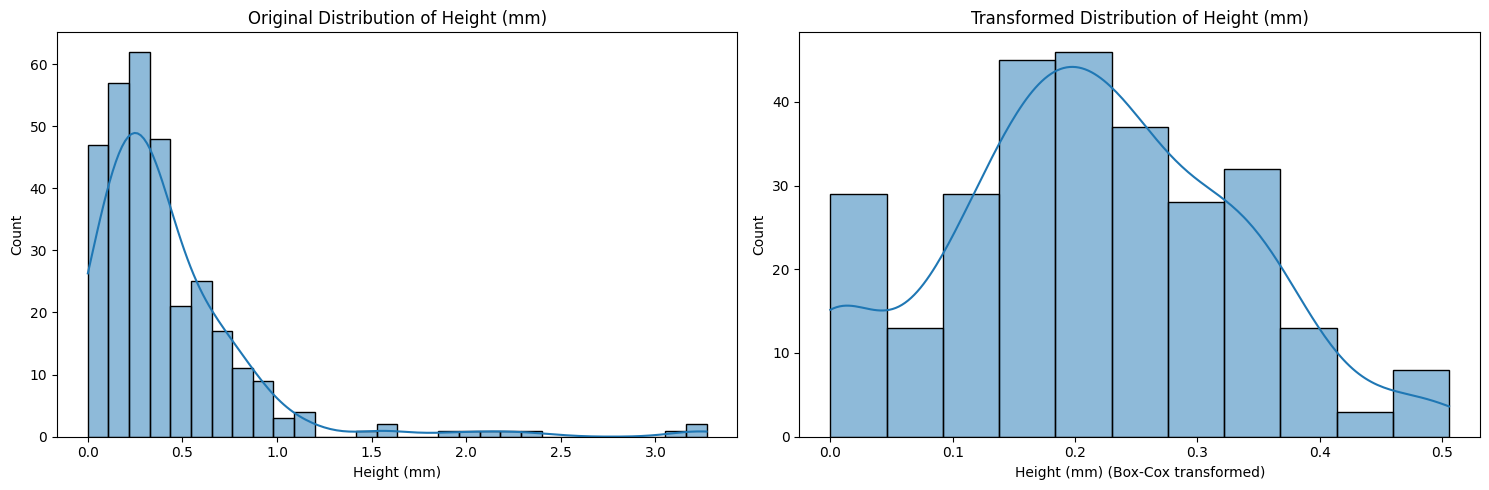

Width (mm)                1.807      0.007


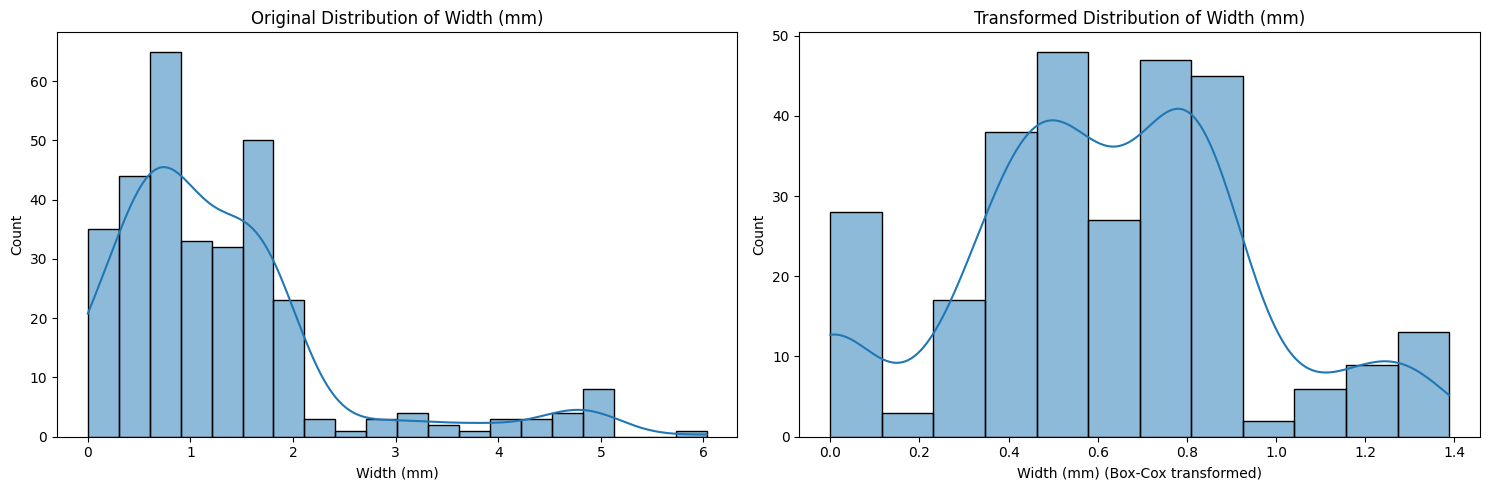

In [17]:
skewed_features = [
    'Spot Size (mm)',
    'Power (W)',
    'Mass Flowrate (g/min)',
    'Travel Velocity (mm/min)',
    'Height (mm)',
    'Width (mm)'
]

df_train_transformed, df_test_transformed, transformer = apply_box_cox_transformation(df_train, df_test, skewed_features)

In [18]:
df_train_transformed.head()

,Powder Material,Substrate Material,Spot Size (mm),Power (W),Mass Flowrate (g/min),Travel Velocity (mm/min),Height (mm),Width (mm),Contact Angle (deg),Aspect Ratio (H/W)
164,PH13-8,Stainless Steel,0.000000,0.839125,0.759631,7.538071,0.265605,0.485995,108.400000,0.621
240,Colmonoy,Steel,1.160099,0.840568,1.811692,7.309282,0.353346,0.979887,79.684211,0.324
124,PH13-8,Stainless Steel,0.000000,0.839428,0.759631,7.338411,0.211851,0.448391,100.300000,0.487
230,CuNiCo,Steel,1.310136,0.840664,2.189231,6.890276,0.503862,1.259503,72.051053,0.709
129,PH13-8,Stainless Steel,0.000000,0.838654,0.891886,7.538071,0.000000,0.000000,0.000000,0.000


In [19]:
df_test_transformed.head()

,Powder Material,Substrate Material,Spot Size (mm),Power (W),Mass Flowrate (g/min),Travel Velocity (mm/min),Height (mm),Width (mm),Contact Angle (deg),Aspect Ratio (H/W)
65,NiCrAlY,Inconel 738,0.978752,0.839512,1.691541,7.578873,0.074956,0.840943,10.000000,0.048
386,Inconel 625,Steel,0.673531,0.840479,1.790801,7.913155,0.351755,0.932364,125.486842,0.356
150,PH13-8,Stainless Steel,0.000000,0.839428,1.086600,6.528499,0.372627,0.599476,118.200000,0.903
158,PH13-8,Stainless Steel,0.000000,0.839125,0.997622,7.338411,0.196392,0.308708,67.000000,0.711
108,PH13-8,Stainless Steel,0.000000,0.839643,0.759631,7.113831,0.267722,0.585490,87.300000,0.477


In [20]:
# Create a new feature that combines both
# Add small constant to Width to avoid division by zero
epsilon = 1e-10
    
df_train_transformed['Size_Width_Ratio'] = df_train_transformed['Spot Size (mm)'] / (df_train_transformed['Width (mm)'] + epsilon)
df_test_transformed['Size_Width_Ratio'] = df_test_transformed['Spot Size (mm)'] / (df_test_transformed['Width (mm)'] + epsilon)

# Drop original features
df_train_transformed = df_train_transformed.drop(['Spot Size (mm)', 'Width (mm)'], axis=1)
df_test_transformed = df_test_transformed.drop(['Spot Size (mm)', 'Width (mm)'], axis=1)

# Handling Categorical Features

## Grouping
- Through EDA, we know that `Powder Material` and `Substrate Matrial` have imbalanced values

- We can try looking if the material properties of similar to form clusters

In [21]:
## Powder Material

# Create dictionary for powder material groups
material_groups = {
    'Nickel_based': ['Inconel 625', 'NiCr', 'NiCrAlY'],
    'Steel_based': ['316L', 'PH13-8'],
    'Cobalt_based': ['Cobalt', 'Colmonoy', 'WC-12Co'],
    'Titanium_based': ['Ti-6Al-4V'],
    'Copper_based': ['CuNiCo']
}

# Create dictionary for substrate material groups
substrate_groups = {
    'Steel_based': ['316L', 'Stainless Steel', 'Steel'],  # All steel variants
    'Nickel_based': ['Inconel 738'],  # Nickel superalloy
    'Titanium_based': ['Ti-6Al-4V']   # Titanium alloy
}

# Function to map material to group
def map_powder_material_to_group(material):
    for group, materials in material_groups.items():
        if material in materials:
            return group
    return 'Other'  # For any materials not in our groups

def map_substrate_material_to_group(material):
    for group, materials in substrate_groups.items():
        if material in materials:
            return group
    return 'Other'  # For any materials not in our groups

# Apply grouping
df_train_transformed['Powder_Material_Group'] = df_train_transformed['Powder Material'].map(lambda x: map_powder_material_to_group(x))
df_train_transformed['Substrate_Material_Group'] = df_train_transformed['Substrate Material'].map(lambda x: map_substrate_material_to_group(x))

df_test_transformed['Powder_Material_Group'] = df_test_transformed['Powder Material'].map(lambda x: map_powder_material_to_group(x))
df_test_transformed['Substrate_Material_Group'] = df_test_transformed['Substrate Material'].map(lambda x: map_substrate_material_to_group(x))


In [22]:
print("\nDistribution of Powder Material Groups:")
print(df_train_transformed['Powder_Material_Group'].value_counts())


Distribution of Powder Material Groups:
Powder_Material_Group
Steel_based       152
Cobalt_based       55
Nickel_based       46
Titanium_based     21
Copper_based        9
Name: count, dtype: int64


In [23]:
df_train_transformed.head()

,Powder Material,Substrate Material,Power (W),Mass Flowrate (g/min),Travel Velocity (mm/min),Height (mm),Contact Angle (deg),Aspect Ratio (H/W),Size_Width_Ratio,Powder_Material_Group,Substrate_Material_Group
164,PH13-8,Stainless Steel,0.839125,0.759631,7.538071,0.265605,108.400000,0.621,0.00000,Steel_based,Steel_based
240,Colmonoy,Steel,0.840568,1.811692,7.309282,0.353346,79.684211,0.324,1.18391,Cobalt_based,Steel_based
124,PH13-8,Stainless Steel,0.839428,0.759631,7.338411,0.211851,100.300000,0.487,0.00000,Steel_based,Steel_based
230,CuNiCo,Steel,0.840664,2.189231,6.890276,0.503862,72.051053,0.709,1.04020,Copper_based,Steel_based
129,PH13-8,Stainless Steel,0.838654,0.891886,7.538071,0.000000,0.000000,0.000,0.00000,Steel_based,Steel_based


In [24]:
df_train_transformed.drop(['Powder Material', 'Substrate Material'],axis=1,inplace=True)
df_test_transformed.drop(['Powder Material', 'Substrate Material'],axis=1,inplace=True)

In [25]:
df_train_transformed['Powder_Material_Group'].value_counts()

Powder_Material_Group
Steel_based       152
Cobalt_based       55
Nickel_based       46
Titanium_based     21
Copper_based        9
Name: count, dtype: int64

# Data Encodings

In [26]:
## One Hot Encoding
from sklearn.preprocessing import OneHotEncoder

# First, let's select the categorical columns
categorical_columns = ['Powder_Material_Group', 'Substrate_Material_Group']

# Initialize the OneHotEncoder
encoder = OneHotEncoder(handle_unknown='ignore')  # drop='first' to avoid dummy variable trap

# Fit and transform the categorical columns
encoded_features_train = encoder.fit_transform(df_train_transformed[categorical_columns]).toarray()
encoded_features_test = encoder.transform(df_test_transformed[categorical_columns]).toarray()

# Get feature names after encoding
feature_names = encoder.get_feature_names_out(categorical_columns)

# Convert encoded features to DataFrame
encoded_df_train = pd.DataFrame(encoded_features_train, 
                         columns=feature_names,
                         index=df_train_transformed.index)

encoded_df_test = pd.DataFrame(encoded_features_test, 
                         columns=feature_names,
                         index=df_test_transformed.index)

# Drop original categorical columns and concatenate encoded features
df_train_transformed = df_train_transformed.drop(columns=categorical_columns)
df_train_transformed = pd.concat([df_train_transformed, encoded_df_train], axis=1)

df_test_transformed = df_test_transformed.drop(columns=categorical_columns)
df_test_transformed = pd.concat([df_test_transformed, encoded_df_test], axis=1)

# Check new feature names
print("\nEncoded features:")
print([col for col in df_train_transformed.columns if 'Powder' in col or 'Substrate' in col])

# Check shapes
print("\nDataset shape:", df_train_transformed.shape)


Encoded features:
['Powder_Material_Group_Cobalt_based', 'Powder_Material_Group_Copper_based', 'Powder_Material_Group_Nickel_based', 'Powder_Material_Group_Steel_based', 'Powder_Material_Group_Titanium_based', 'Substrate_Material_Group_Nickel_based', 'Substrate_Material_Group_Steel_based', 'Substrate_Material_Group_Titanium_based']

Dataset shape: (283, 15)


In [27]:
df_test_transformed.columns

Index(['Power (W)', 'Mass Flowrate (g/min)', 'Travel Velocity (mm/min)',
       'Height (mm)', 'Contact Angle (deg)', 'Aspect Ratio (H/W)',
       'Size_Width_Ratio', 'Powder_Material_Group_Cobalt_based',
       'Powder_Material_Group_Copper_based',
       'Powder_Material_Group_Nickel_based',
       'Powder_Material_Group_Steel_based',
       'Powder_Material_Group_Titanium_based',
       'Substrate_Material_Group_Nickel_based',
       'Substrate_Material_Group_Steel_based',
       'Substrate_Material_Group_Titanium_based'],
      dtype='object')

In [28]:
df_train_transformed.columns

Index(['Power (W)', 'Mass Flowrate (g/min)', 'Travel Velocity (mm/min)',
       'Height (mm)', 'Contact Angle (deg)', 'Aspect Ratio (H/W)',
       'Size_Width_Ratio', 'Powder_Material_Group_Cobalt_based',
       'Powder_Material_Group_Copper_based',
       'Powder_Material_Group_Nickel_based',
       'Powder_Material_Group_Steel_based',
       'Powder_Material_Group_Titanium_based',
       'Substrate_Material_Group_Nickel_based',
       'Substrate_Material_Group_Steel_based',
       'Substrate_Material_Group_Titanium_based'],
      dtype='object')

In [29]:
df_train_transformed.head()

,Power (W),Mass Flowrate (g/min),Travel Velocity (mm/min),Height (mm),Contact Angle (deg),Aspect Ratio (H/W),Size_Width_Ratio,Powder_Material_Group_Cobalt_based,Powder_Material_Group_Copper_based,Powder_Material_Group_Nickel_based,Powder_Material_Group_Steel_based,Powder_Material_Group_Titanium_based,Substrate_Material_Group_Nickel_based,Substrate_Material_Group_Steel_based,Substrate_Material_Group_Titanium_based
164,0.839125,0.759631,7.538071,0.265605,108.400000,0.621,0.00000,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
240,0.840568,1.811692,7.309282,0.353346,79.684211,0.324,1.18391,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
124,0.839428,0.759631,7.338411,0.211851,100.300000,0.487,0.00000,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
230,0.840664,2.189231,6.890276,0.503862,72.051053,0.709,1.04020,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
129,0.838654,0.891886,7.538071,0.000000,0.000000,0.000,0.00000,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0


In [30]:
X_train = df_train_transformed.drop('Aspect Ratio (H/W)', axis=1)
y_train = df_train_transformed['Aspect Ratio (H/W)']

X_test= df_test_transformed.drop('Aspect Ratio (H/W)', axis=1)
y_test = df_test_transformed['Aspect Ratio (H/W)']

In [38]:
X_train.head()

,Power (W),Mass Flowrate (g/min),Travel Velocity (mm/min),Height (mm),Contact Angle (deg),Size_Width_Ratio,Powder_Material_Group_Cobalt_based,Powder_Material_Group_Copper_based,Powder_Material_Group_Nickel_based,Powder_Material_Group_Steel_based,Powder_Material_Group_Titanium_based,Substrate_Material_Group_Nickel_based,Substrate_Material_Group_Steel_based,Substrate_Material_Group_Titanium_based
164,0.839125,0.759631,7.538071,0.265605,108.400000,0.00000,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
240,0.840568,1.811692,7.309282,0.353346,79.684211,1.18391,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
124,0.839428,0.759631,7.338411,0.211851,100.300000,0.00000,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
230,0.840664,2.189231,6.890276,0.503862,72.051053,1.04020,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
129,0.838654,0.891886,7.538071,0.000000,0.000000,0.00000,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0


In [39]:
y_train.head()

164    0.621
240    0.324
124    0.487
230    0.709
129    0.000
Name: Aspect Ratio (H/W), dtype: float64

In [31]:
#Checking if new derived feature has infinity values
for column in X_train.columns:
    if np.any(np.isinf(X_train[column])):
        print(f"Infinity found in training set - column: {column}")
    if np.any(np.isinf(X_test[column])):
        print(f"Infinity found in test set - column: {column}")

# Modelling

In [32]:
import statsmodels.api as sm
# Add a constant term for the intercept
X_train_sm = sm.add_constant(X_train)
X_test_sm = sm.add_constant(X_test)

# Fit the model
model = sm.OLS(y_train, X_train_sm).fit()

# Print the model summary
from IPython.display import display, HTML
display(HTML(model.summary().as_html()))

In [33]:
import pickle
import os

def train_tune_evaluate_models(X_train, X_test, y_train, y_test, cv=5):
    """
    Train, tune, evaluate models using existing train-test split
    
    Parameters:
    -----------
    X_train, X_test : training and test features
    y_train, y_test : training and test target
    cv : number of folds for cross-validation during tuning
    """
    
    # Create a directory to store the models if it doesn't exist
    if not os.path.exists('./saved_models'):
        os.makedirs('./saved_models')
    
    # Parameter grids
    param_grids = {
        'Linear Regression': {
            'model': LinearRegression(),
            'params': {}
        },
        'Random Forest': {
            'model': RandomForestRegressor(random_state=42),
            'params': {
                'n_estimators': [100, 200, 300],
                'max_depth': [None, 10, 20, 30],
                'min_samples_split': [2, 5, 10],
                'min_samples_leaf': [1, 2, 4]
            }
        },
        'XGBoost': {
            'model': xgb.XGBRegressor(random_state=42),
            'params': {
                'n_estimators': [100, 200, 300],
                'max_depth': [3, 4, 5, 6],
                'learning_rate': [0.001, 0.01],
                'subsample': [0.6, 0.8, 1.0],
                'colsample_bytree': [0.8, 0.9, 1.0],
                'sampling_method': ['uniform','gradient_based'],
                'lambda': [1, 1.1, 1.2],
                'eta':[0.3, 0.4, 0.5],
                'tree_method': ['exact', 'auto'],

            }
        }
    }
    
    results = {}
    
    # Plot original target distributions
    plt.figure(figsize=(12, 5))
    plt.subplot(121)
    sns.histplot(y_train, kde=True, label='Train')
    plt.title('Training Target Distribution')
    plt.xlabel('Target Value')
    
    plt.subplot(122)
    sns.histplot(y_test, kde=True, label='Test')
    plt.title('Test Target Distribution')
    plt.xlabel('Target Value')
    plt.tight_layout()
    plt.show()
    
    for name, model_info in param_grids.items():
        print(f"\nTuning {name}...")
        
        # GridSearchCV on training data
        grid_search = GridSearchCV(
            estimator=model_info['model'],
            param_grid=model_info['params'],
            cv=cv,
            scoring='r2',
            n_jobs=-1,
            verbose=1
        )
        
        # Fit on training data
        grid_search.fit(X_train, y_train)
        
        # Get best model
        best_model = grid_search.best_estimator_

        # Save the best model using pickle
        model_filename = os.path.join('./saved_models', f'{name.lower().replace(" ", "_")}_best_model.pkl')
        with open(model_filename, 'wb') as file:
            pickle.dump(best_model, file)
        print(f"Saved best {name} model to {model_filename}")
        
        # Make predictions
        train_pred = best_model.predict(X_train)
        test_pred = best_model.predict(X_test)
        
        # Store results
        results[name] = {
            'model': best_model,
            'best_params': grid_search.best_params_,
            'train_pred': train_pred,
            'test_pred': test_pred,
            'train_r2': r2_score(y_train, train_pred),
            'test_r2': r2_score(y_test, test_pred),
            'train_rmse': np.sqrt(mean_squared_error(y_train, train_pred)),
            'test_rmse': np.sqrt(mean_squared_error(y_test, test_pred))
        }
        
        print(f"\nBest parameters for {name}:")
        print(grid_search.best_params_)
        print(f"Train R² Score: {results[name]['train_r2']:.4f}")
        print(f"Test R² Score: {results[name]['test_r2']:.4f}")
        print(f"Train RMSE: {results[name]['train_rmse']:.4f}")
        print(f"Test RMSE: {results[name]['test_rmse']:.4f}")
        
        # Plotting
        fig, axes = plt.subplots(2, 2, figsize=(15, 12))
        
        # Train predictions
        axes[0,0].scatter(y_train, train_pred, alpha=0.5)
        axes[0,0].plot([y_train.min(), y_train.max()], 
                      [y_train.min(), y_train.max()], 'r--', lw=2)
        axes[0,0].set_xlabel('Actual')
        axes[0,0].set_ylabel('Predicted')
        axes[0,0].set_title(f'{name}: Train Predictions\nR² = {results[name]["train_r2"]:.4f}')
        
        # Test predictions
        axes[0,1].scatter(y_test, test_pred, alpha=0.5)
        axes[0,1].plot([y_test.min(), y_test.max()], 
                      [y_test.min(), y_test.max()], 'r--', lw=2)
        axes[0,1].set_xlabel('Actual')
        axes[0,1].set_ylabel('Predicted')
        axes[0,1].set_title(f'{name}: Test Predictions\nR² = {results[name]["test_r2"]:.4f}')
        
        # Residuals
        train_residuals = y_train - train_pred
        test_residuals = y_test - test_pred
        
        axes[1,0].scatter(train_pred, train_residuals, alpha=0.5)
        axes[1,0].axhline(y=0, color='r', linestyle='--')
        axes[1,0].set_xlabel('Predicted')
        axes[1,0].set_ylabel('Residuals')
        axes[1,0].set_title('Train Residuals')
        
        axes[1,1].scatter(test_pred, test_residuals, alpha=0.5)
        axes[1,1].axhline(y=0, color='r', linestyle='--')
        axes[1,1].set_xlabel('Predicted')
        axes[1,1].set_ylabel('Residuals')
        axes[1,1].set_title('Test Residuals')
        
        plt.tight_layout()
        plt.show()
        
        # Feature importance for tree-based models
        if name in ['Random Forest', 'XGBoost']:
            plt.figure(figsize=(10, 6))
            importance = pd.DataFrame({
                'feature': X_train.columns,
                'importance': best_model.feature_importances_
            }).sort_values('importance', ascending=False)
            
            sns.barplot(data=importance.head(10), x='importance', y='feature')
            plt.title(f'{name}: Feature Importance')
            plt.tight_layout()
            plt.show()
    
    # Compare all models
    model_comparison = pd.DataFrame({
        'Train R²': [results[model]['train_r2'] for model in results.keys()],
        'Test R²': [results[model]['test_r2'] for model in results.keys()],
        'Train RMSE': [results[model]['train_rmse'] for model in results.keys()],
        'Test RMSE': [results[model]['test_rmse'] for model in results.keys()]
    }, index=results.keys())
    
    print("\nModel Comparison:")
    print(model_comparison)
    
    # Plot model comparison
    plt.figure(figsize=(12, 6))
    model_comparison[['Train R²', 'Test R²']].plot(kind='bar')
    plt.title('Model Comparison: R² Scores')
    plt.xlabel('Model')
    plt.ylabel('R² Score')
    plt.xticks(rotation=45)
    plt.legend()
    plt.tight_layout()
    plt.show()
    
    return results, model_comparison

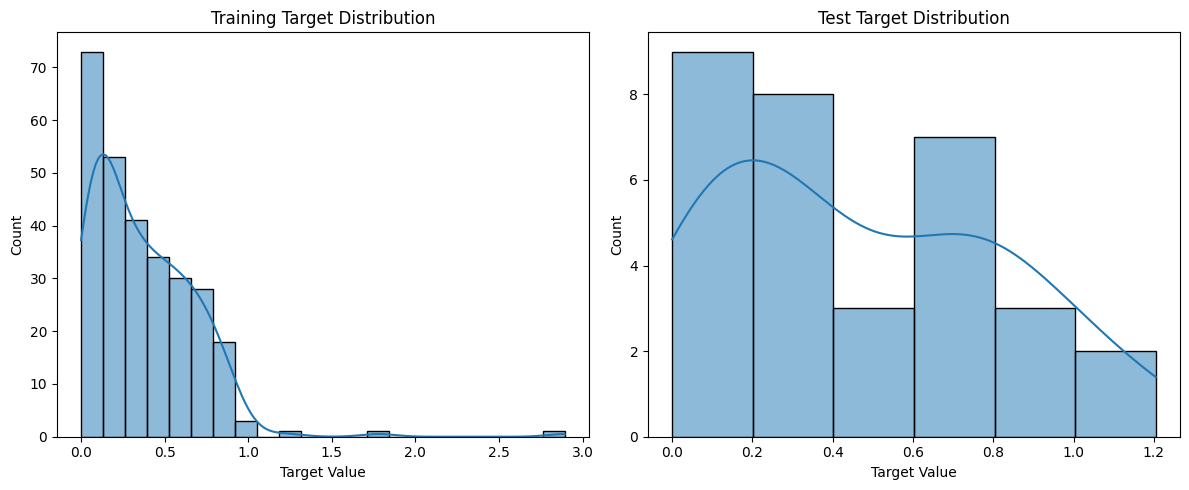


Tuning Linear Regression...
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Saved best Linear Regression model to ./saved_models\linear_regression_best_model.pkl

Best parameters for Linear Regression:
{}
Train R² Score: 0.8404
Test R² Score: 0.8416
Train RMSE: 0.1285
Test RMSE: 0.1377


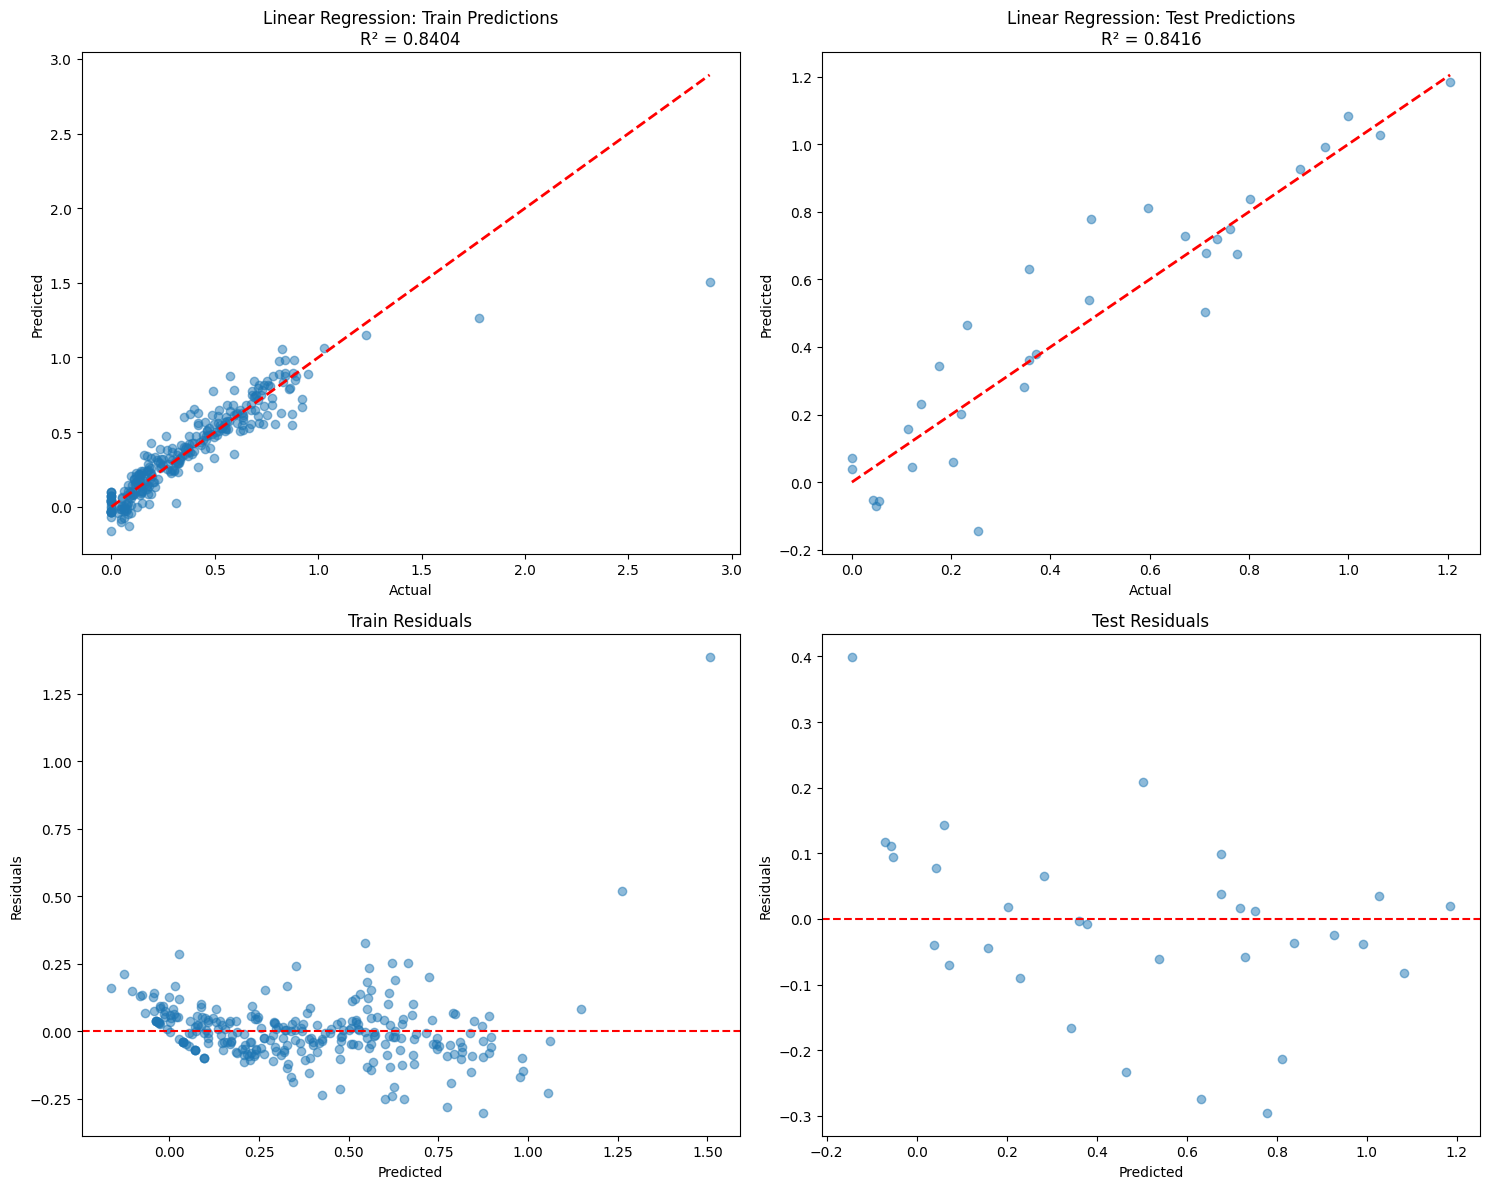


Tuning Random Forest...
Fitting 5 folds for each of 108 candidates, totalling 540 fits
Saved best Random Forest model to ./saved_models\random_forest_best_model.pkl

Best parameters for Random Forest:
{'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Train R² Score: 0.9824
Test R² Score: 0.9202
Train RMSE: 0.0427
Test RMSE: 0.0978


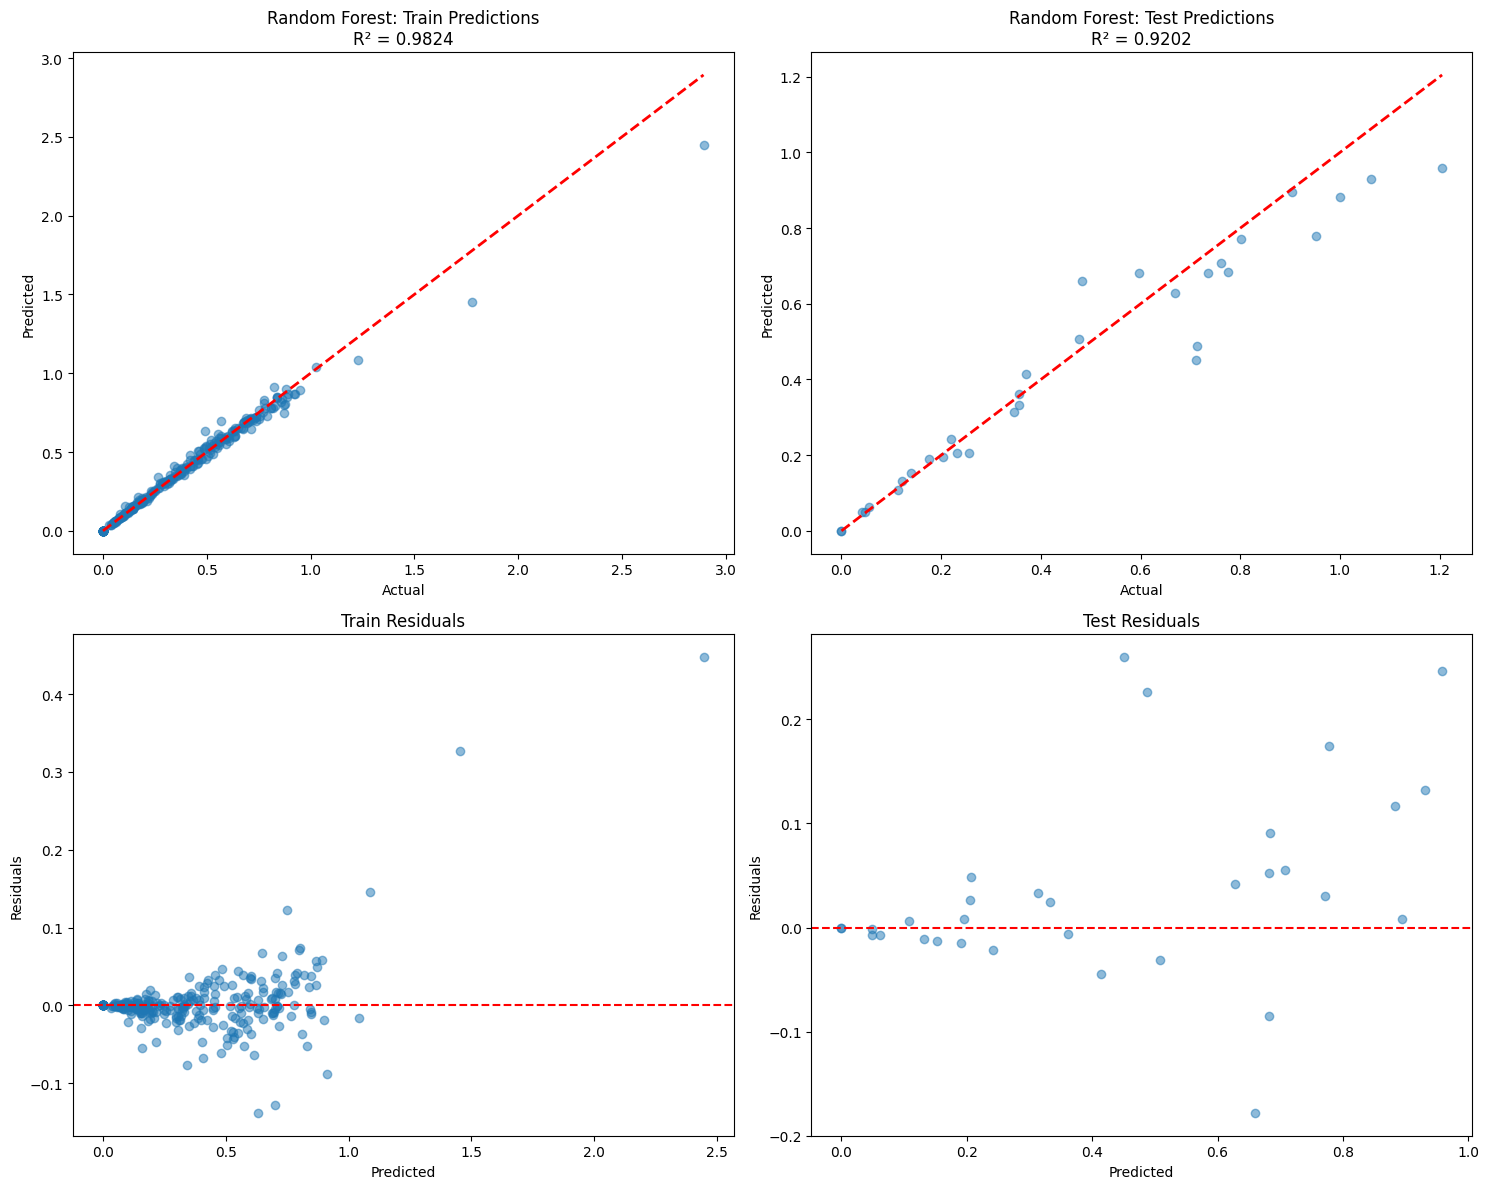

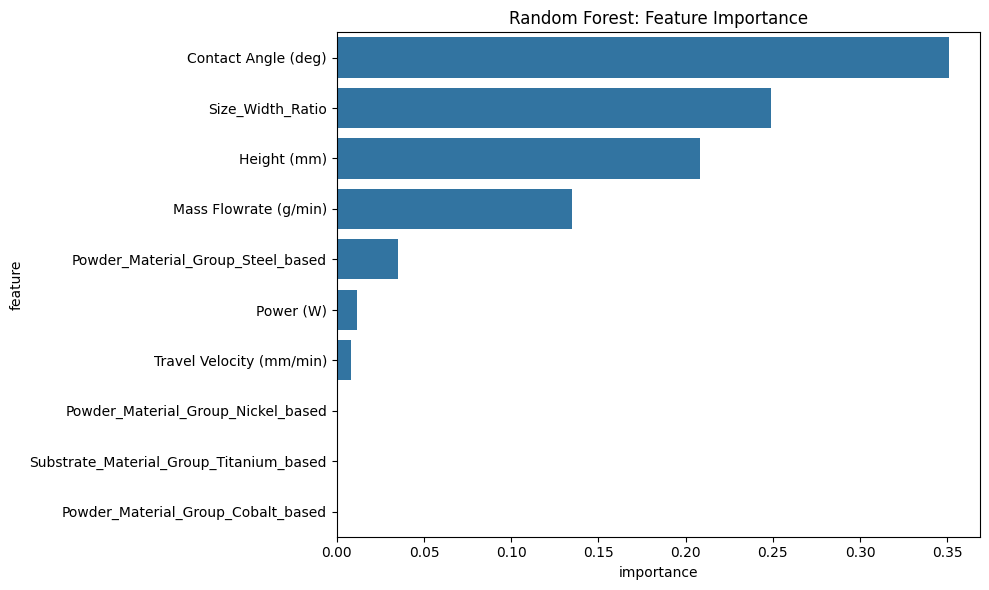


Tuning XGBoost...
Fitting 5 folds for each of 7776 candidates, totalling 38880 fits


c:\Users\Pratik\anaconda3\envs\ras598\lib\site-packages\sklearn\model_selection\_validation.py:540: FitFailedWarning: 
16200 fits failed out of a total of 38880.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\Pratik\anaconda3\envs\ras598\lib\site-packages\sklearn\model_selection\_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\Pratik\anaconda3\envs\ras598\lib\site-packages\xgboost\core.py", line 726, in inner_f
    return func(**kwargs)
  File "c:\Users\Pratik\anaconda3\envs\ras598\lib\site-packages\xgboost\sklearn.py", line 1108, in fit
    self._Booster = train(
  File "c:\Users\Pra

Saved best XGBoost model to ./saved_models\xgboost_best_model.pkl

Best parameters for XGBoost:
{'colsample_bytree': 1.0, 'eta': 0.3, 'lambda': 1, 'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 300, 'sampling_method': 'uniform', 'subsample': 0.8, 'tree_method': 'exact'}
Train R² Score: 0.9685
Test R² Score: 0.9299
Train RMSE: 0.0571
Test RMSE: 0.0916


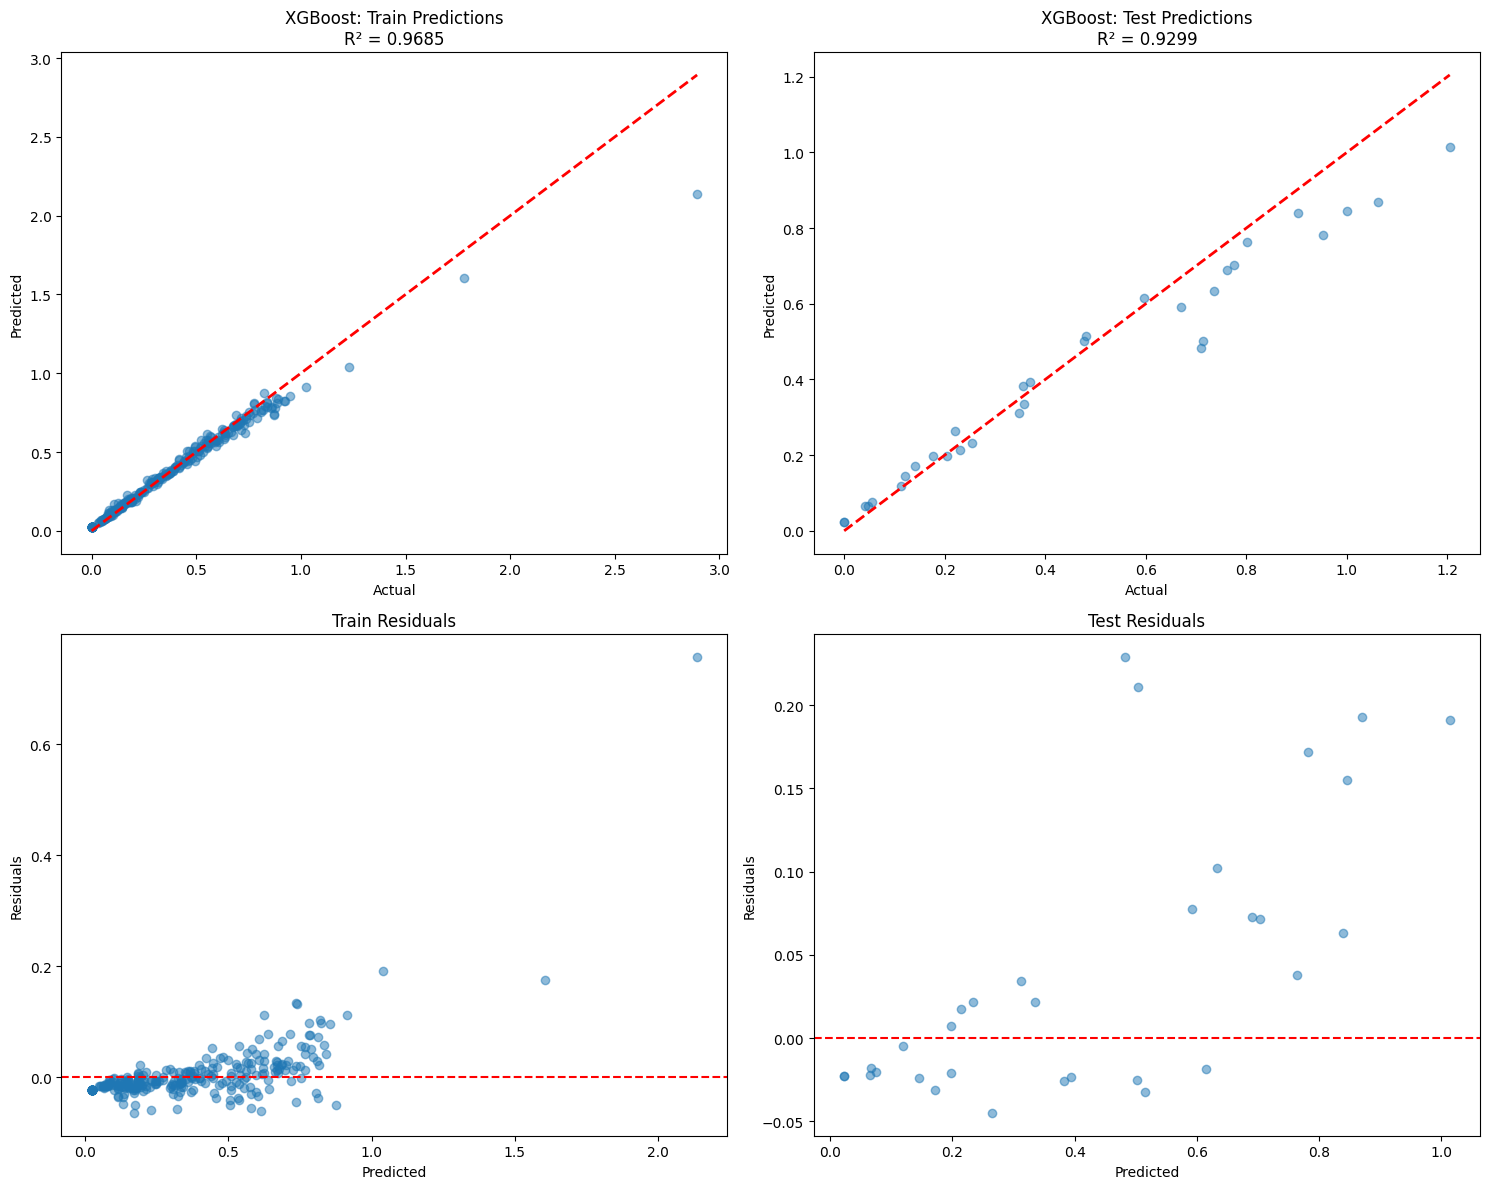

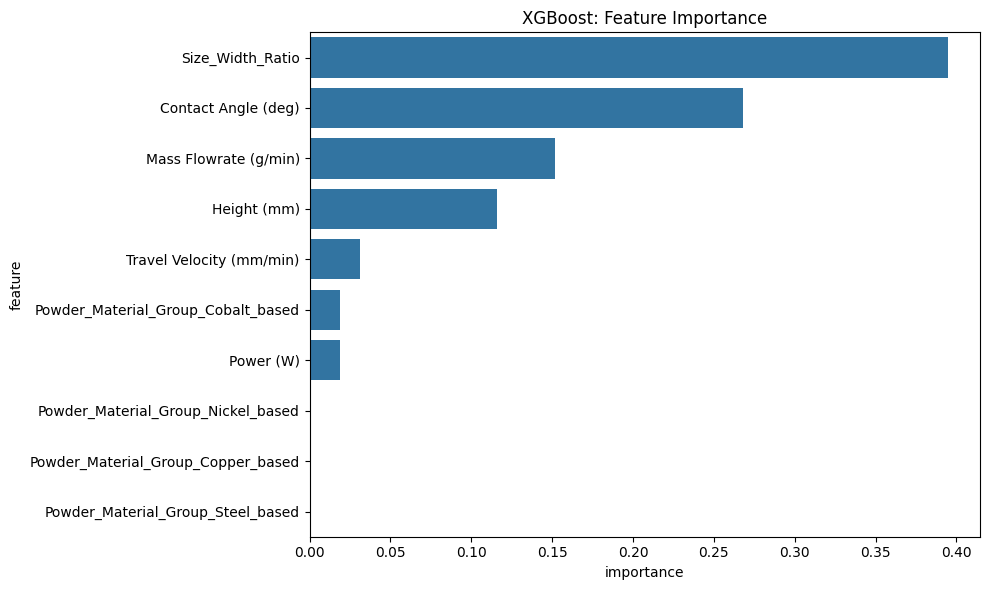


Model Comparison:
                   Train R²   Test R²  Train RMSE  Test RMSE
Linear Regression  0.840368  0.841591    0.128513   0.137732
Random Forest      0.982413  0.920156    0.042656   0.097784
XGBoost            0.968504  0.929919    0.057084   0.091610


<Figure size 1200x600 with 0 Axes>

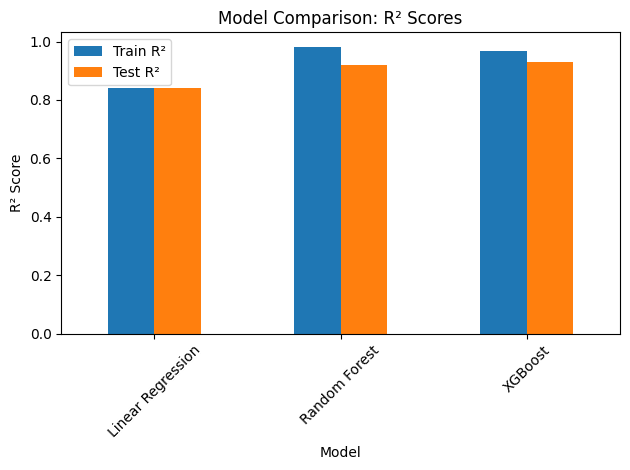

In [34]:
results, model_comparison = train_tune_evaluate_models(
    X_train, X_test, 
    y_train, y_test, 
    cv=5
)

<Axes: xlabel='Aspect Ratio (H/W)', ylabel='Count'>

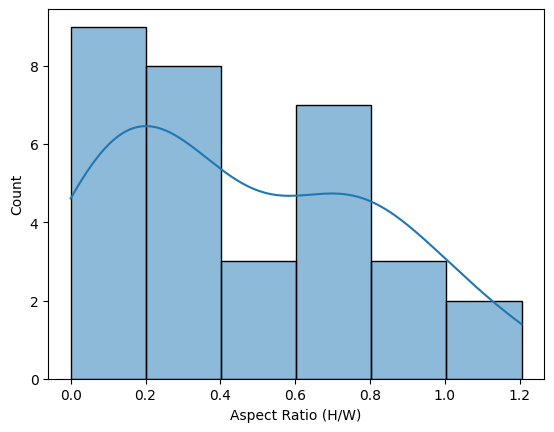

In [35]:
sns.histplot(y_test, kde=True)

<Axes: xlabel='Aspect Ratio (H/W)', ylabel='Count'>

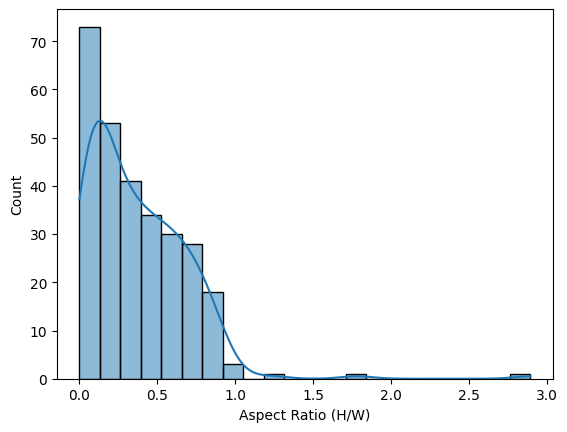

In [36]:
sns.histplot(y_train, kde=True)